In [6]:
import numpy as np
import pandas as pd
from econml.dml import CausalForestDML
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.base import BaseEstimator
from econml.sklearn_extensions.model_selection import GridSearchCVList
import time
import joblib
import multiprocessing
import pickle
import config
from utils import *

rank 20 model loaded!
rank 40 model loaded!
rank 60 model loaded!
rank 80 model loaded!
rank 100 model loaded!
rank 20 model loaded!
rank 40 model loaded!
rank 60 model loaded!
rank 80 model loaded!
rank 100 model loaded!
rank 20 model loaded!
rank 40 model loaded!
rank 60 model loaded!
rank 80 model loaded!
rank 100 model loaded!


In [3]:


# For ignoring the warnings
from warnings import simplefilter, filterwarnings
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None



base_ad = 50
max_adv_rank = 100
max_visit_no = 100 # max number of page visits by each user

# read data
data = pd.read_stata("..\\data\\Simulation Data - Last 2 Days.dta")

In [50]:
data_sample = data[data.index % 1000 == 0] 

In [23]:
data_sample

,global_token_new,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,sub_23,sub_24,sub_25,sub_26,prop,day,ad,ads_on_page,user_visit_no,mobile
0,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.076182,6,1,5,1,1
1000,336.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.029428,6,1,1,1,1
2000,691.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.052213,6,1,8,16,1
3000,1104.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.055740,6,1,11,5,1
4000,1379.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.044718,7,1,7,39,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4812000,1615847.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.076182,7,1,4,2,1
4813000,1616219.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.076182,6,1,11,4,1
4814000,1616609.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.051908,7,1,4,31,1
4815000,1616980.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0.100952,7,1,5,3,1


In [70]:
# for ad rank 1:
data_sample['user_visit_no'] = 1
data_sample['impression_repeat_base_ad'] = 1

for repeat in range(1, 11):
    var_name = f"te_r_{repeat}"
    data_sample[var_name] = 0

for rank in range(1, 21):
    X = construct_X(data_sample, user_visit_no=1, ad_rank=1)
    for repeat in range(1, 11):
        X['impression_repeat'] = repeat
        var_name = f"te_r_{repeat}"
        var_name_2 = f"te_{rank}_r_{repeat}"
        exec(f"data_sample[var_name_2] = config.cf_{rank}.const_marginal_effect(X)")
        data_sample[var_name] += data_sample[var_name_2] 



In [43]:
data_sample.loc[:, 'te_1_r_1': 'te_1_r_10'] 

,te_1_r_1,te_1_r_2,te_1_r_3,te_1_r_4,te_1_r_5,te_1_r_6,te_1_r_7,te_1_r_8,te_1_r_9,te_1_r_10
0,0.001420,0.001136,0.001269,0.001637,0.001726,0.001924,0.001871,0.001831,0.001735,0.001836
1,0.002015,0.001692,0.001811,0.001890,0.002029,0.002216,0.002183,0.002167,0.002156,0.002290
2,0.002015,0.001692,0.001811,0.001890,0.002029,0.002216,0.002183,0.002167,0.002156,0.002290
3,0.001330,0.001376,0.001227,0.001532,0.001654,0.001755,0.001697,0.001673,0.001570,0.001605
4,0.000769,0.000603,0.000214,0.000507,0.000548,0.000671,0.000652,0.000715,0.000700,0.000716
...,...,...,...,...,...,...,...,...,...,...
4816658,0.000616,0.000981,0.000498,0.000591,0.000473,0.000284,0.000263,0.000240,0.000177,0.000276
4816659,0.000616,0.000981,0.000498,0.000591,0.000473,0.000284,0.000263,0.000240,0.000177,0.000276
4816660,0.000616,0.000981,0.000498,0.000591,0.000473,0.000284,0.000263,0.000240,0.000177,0.000276
4816661,0.001087,0.000912,0.001006,0.001166,0.001350,0.001404,0.001457,0.001397,0.001356,0.001351


In [71]:
data_sample.loc[:, 'te_r_1': 'te_r_10'].agg('mean')

te_r_1    -0.002412
te_r_2    -0.000073
te_r_3     0.000916
te_r_4     0.001324
te_r_5     0.001663
te_r_6     0.002057
te_r_7     0.002126
te_r_8     0.002003
te_r_9     0.001561
te_r_10    0.001509
dtype: float64

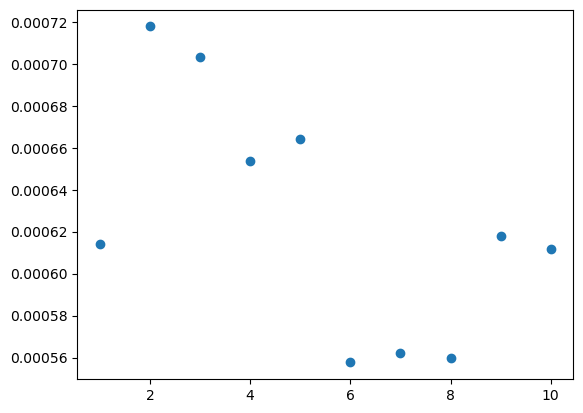

In [73]:
plt.scatter(range(1, 11), data_sample.loc[:, 'te_1_r_1': 'te_1_r_10'].agg('mean'))